- This notebook is to compare some summary statistics between oma releases (number and size of OMA Groups, HOGs, added or removed genomes/taxa levels, number of homoeolog pairs, etc)
- By: Natasha Glover
- Last updated: 
   - Natasha: 13 Aug 2018
   - Adrian:  12 Jul 2019
   - Adrian:  04 Jan 2021


# Setup

In [1]:
# Scientific libraries
import numpy as np
#from scipy import stats
import pandas as pd
import tables
import pandas

#basic python libraries
import re
import os

# Pyoma libraries
from pyoma.browser import sanitychecks

# Graphic libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Aesthetics

In [2]:
# Extra options
pd.set_option('max_colwidth',200)
pd.options.display.max_rows = 150

#style options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12.0, 8.0)

#seaborn options
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale=1.5)
sns.set_style('whitegrid')
palette="husl"

## Mounting the oma browser directory

To compare oma browser releases, I use the hdf5 file from each. However, since they are so big (~50 Gb each), I mount the directory on vital-it where they are contained. This is done with sshfs and needs to be mounted before the following analyses. The following command is done from command line:
- sshfs nglover@prd.vital-it.ch:/data/ul/projects/cdessimo/oma-browser ~/oma_mount

## Parameters

TODO: Make it so that it just detects all the databases automatically and then we can run the notebook automatically after each release.

In [3]:
#directory containing the different oma browser releases
oma_browser_dir = os.path.expanduser(os.getenv("DARWIN_BROWSER_SHARE", "~/oma_mount/"))

#list of 4 releases (strings) to be compared (only exactly 4 for now)
#note they will be plotted and presented in the order specified in list
releases = ["All.Dec2018", "All.Jun2019", "All.Aug2020", "All.Apr2021"]

# Running the sanity checks

The following code does all the heavy lifting and uses the sanitychecks2 library from pyoma. Since this involves making many computations, especially from the Entries table in each database, this could take a while to run (~40 minutes).

In [4]:
#import importlib
#importlib.reload(sanitychecks)

#list of sanity (release) objects, each one corresponding to a different release
sanity_sessions = []

for release in releases:
    release_obj = sanitychecks.SanitySession(oma_browser_dir, release)
    sanity_sessions.append(release_obj)

/scratch/axiom/FAC/FBM/DBC/cdessim2/oma/venv/lib64/python3.6/site-packages/tables/leaf.py:410: PerformanceWarning: The Leaf ``/Protein/_i_Entries/OmaHOG/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)
/scratch/axiom/FAC/FBM/DBC/cdessim2/oma/venv/lib64/python3.6/site-packages/tables/leaf.py:410: PerformanceWarning: The Leaf ``/_i_HogLevel/ID/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to th

All.Dec2018 done


processing xref-chunks: 100%|██████████| 12487/12487 [05:45<00:00, 36.09it/s]


All.Jun2019 done


/scratch/axiom/FAC/FBM/DBC/cdessim2/oma/venv/lib64/python3.6/site-packages/tables/leaf.py:410: PerformanceWarning: The Leaf ``/_i_XRef/XRefId/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)
processing xref-chunks: 100%|██████████| 13538/13538 [07:00<00:00, 32.23it/s]


All.Aug2020 done


processing xref-chunks: 100%|██████████| 15005/15005 [08:00<00:00, 31.25it/s]


All.Apr2021 done


# Functions

In [5]:
#TODO add these functions to the sanity checks module

In [6]:
def _return_group_object(release_obj, group):
    if group == "hog":
        group_obj = release_obj.all_hogs
    if group == "omagroup":
        group_obj = release_obj.omagroups
    return group_obj

def count_nb_groups(release_obj, group):
    df = pd.DataFrame.from_dict(_return_group_object(release_obj, group), orient='index')
    df['release'] = release_obj.release    
    return df.groupby('release').size().item()

def get_nb_genes_per_group_df(release_obj, group):
    df = pd.DataFrame.from_dict(_return_group_object(release_obj, group), orient='index')
    df['release'] = release_obj.release
    df.reset_index(inplace=True) 
    df.rename({0:"nb_genes", "index":group}, inplace=True, axis=1)    
    return df

def sort_df_by_release(df):
    df.release = df.release.astype("category")
    df.release.cat.set_categories(releases, inplace=True)
    df = df.sort_values("release")
    return df

def cum_bin_cnts_by_release(df, column, bin_width=10):
    """return the cumulative counts of the number of groups that have
    at least the size of the bin value"""
    bins = np.arange(0, max(df[column])+bin_width, bin_width)
    dfq = pandas.DataFrame({rel: np.histogram(df[df['release']==rel][column], bins)[0] 
                            for rel in df['release'].unique()})
    cum = dfq.iloc[::-1].cumsum()
    cum['bin'] = bins[:-1][::-1]
    cum['lab'] = np.array(list(">{}".format(z) for z in bins[:-1]))[::-1]
    return cum

def make_countplot_by_release(df, releases, title="Don't forget a title"):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    ax = sns.countplot(x="release", data=df, order=releases, palette="husl")
    ax.set_title(title)
    return ax

def get_differences_in_genomes_or_taxa(df, old_release, new_release, genomes_or_taxa):
    '''old_release and new_release should be sanity session objects'''
    
    if genomes_or_taxa == "genomes":
        added = list(set(new_release.species) - set(old_release.species))
        removed = list(set(old_release.species) - set(new_release.species))
        
    if genomes_or_taxa == "taxa":
        added = list(set(new_release.all_hog_lvls) - set(old_release.all_hog_lvls))
        removed = list(set(old_release.all_hog_lvls) - set(new_release.all_hog_lvls))
        added = [x.decode("utf-8") for x in added]
        removed = [x.decode("utf-8") for x in removed]
    res = {'added':added, 'removed': removed}
    return res

def decode_column_in_df(df, column_to_decode):
    df[column_to_decode] = df.apply(lambda x: x[column_to_decode].decode("utf-8"), axis=1)
    return df

def make_boxplot_by_release(df, releases, column_to_plot, title="Don't forget a title"):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
    sns.boxplot(x="release", y=column_to_plot, data=df, ax=ax[0], palette=palette, order=releases)
    ax[0].set_title("Outliers shown")
    sns.boxplot(x="release", y=column_to_plot, data=df, ax=ax[1], showfliers=False, palette=palette, order=releases)
    ax[1].set_title("No outliers shown")
    plt.suptitle(title)
    plt.subplots_adjust(top=0.75)
    plt.show()
    
def make_cumbiggerthan_plot_by_release(cum_df, releases, title="Don't forget a title", xlabel="Size", ylabel="Cumulative counts"):
    pal = matplotlib.colors.ListedColormap(sns.color_palette(palette, len(releases)))
    fig, ax = plt.subplots()
    for num, rel in enumerate(releases):
        plt.plot('bin', rel, data=cum_df, marker='', color=pal(num), linewidth=2.4, alpha=0.9, label=rel)
    plt.semilogy()
    xstep = len(cum_df)//20
    if cum_df['bin'][0]>0:
        xstep = -xstep
    plt.xticks(cum_df['bin'][::xstep], fontsize=15, rotation=45)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=15)
    plt.show()
    
def get_prop_with_n_genes(df, releases, nb_genes=2):
    '''get number of groups per release
    param releases is the list of string releases'''
    df1 = df.groupby('release').size().reset_index()
    df1.rename({0:'total_nb_groups'}, axis=1, inplace=True)

    #get groups with n genes
    df2 = df[df['nb_genes']==nb_genes].groupby('release').size().reset_index()
    df2.rename({0:'nb_groups_with_'+str(nb_genes)+'_genes'}, axis=1, inplace=True)
    
    #get proportion
    df3 = pd.merge(left=df1, right=df2, how="left", on="release")
    df3['prop_groups_'+str(nb_genes)+'_genes'] = df3['nb_groups_with_'+str(nb_genes)+'_genes']/ df3['total_nb_groups']
    df3.set_index("release", inplace=True)
    df3 = df3.reindex(releases)
    df3.reset_index(level=0, inplace=True)
    return df3

def get_total_nb_groups(df):
    df = df.groupby('release').size().reset_index()
    df.rename({0:"nb_genomes"}, axis=1, inplace=True)
    df = sort_df_by_release(df) 
    return df

def get_summary_stats(df, column_to_summarize):
    df= df[['release',column_to_summarize]].groupby('release').describe().reset_index()
    df.columns = df.columns.droplevel()
    df = df.rename({'':'release'}, axis=1)
    df = sort_df_by_release(df)
    return df

def plot_proportions_of_groups_with_n_genes(low_genes_df, list_of_columns_to_plot,\
                                            title="Don't forget a title", rename_cols=False):
    
    if rename_cols==True:
        low_genes_df = rename_proportion_columns(low_genes_df)
        list_of_columns_to_plot = rename_proportion_columns(low_genes_df).columns[1:5]
        
    
    #melt dataframe
    melted_low_genes_df = pd.melt(low_genes_df, id_vars=['release'], \
                                  value_vars=list_of_columns_to_plot)
    melted_low_genes_df.rename({"variable": "nb genes in group", "value": "proportion of groups"}, \
                               axis=1, inplace=True)
    
    #make plot
    fig, ax= plt.subplots(figsize=(10,10))
    sns.pointplot(x="release", y="proportion of groups", hue="nb genes in group", data=melted_low_genes_df, \
                 palette=palette)
    #plt.legend(loc="upper right")
    plt.ylim(0,.7)
    plt.title(title)
    plt.show()

def get_low_genes_df(df, releases, list_of_gene_numbers=[2,3,4,5]):
    '''makes a dataframe with proportion of genes with n number for each release.'''
    low_genes_df = pd.DataFrame.from_dict({'release': releases})

    for i in range(list_of_gene_numbers[0],list_of_gene_numbers[-1]+1):
        tmp_df = pd.DataFrame(get_prop_with_n_genes(df, releases, i))
        low_genes_df = pd.merge(left=low_genes_df, right=tmp_df[['release',tmp_df.columns[-1]]],\
                                how="left", on="release")

    low_genes_df['total_nb_groups'] = get_prop_with_n_genes(df, releases, 2)['total_nb_groups']
    return low_genes_df

def rename_proportion_columns(df):
    columns = df.columns
    new_columns = {}
    for column in columns:
        if "prop_groups" in column:
            matchObj = re.match(r'prop_groups_(.*)_genes', column)
            try:
                new_column = matchObj.group(1)
                new_columns[column] = new_column
            except:
                print("no match")
    
    df = df.rename(new_columns, axis=1)
    return df


# Compare Genomes

In [7]:
#get genome dataframe
genome_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = pd.DataFrame.from_dict({'genomes': release.species})
    tmp_df['release'] = release.release
    genome_df = genome_df.append(tmp_df)

## Nb of genomes

In [8]:
get_total_nb_groups(genome_df)

release  nb_genomes
2  All.Dec2018        2198
3  All.Jun2019        2288
1  All.Aug2020        2326
0  All.Apr2021        2424

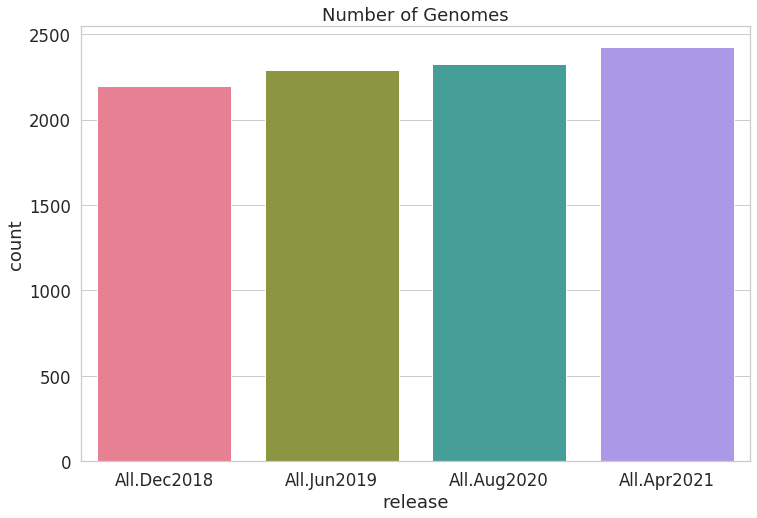

In [9]:
make_countplot_by_release(genome_df, releases, "Number of Genomes")

## Genomes added

In [10]:
#latest genomes added
genome1_df = pd.DataFrame(sanity_sessions[-2].genome_table.read())
genome1_df = decode_column_in_df(genome1_df, "UniProtSpeciesCode")
genome2_df = pd.DataFrame(sanity_sessions[-1].genome_table.read())
genome2_df = decode_column_in_df(genome2_df, "UniProtSpeciesCode")

diff = get_differences_in_genomes_or_taxa(genome_df, sanity_sessions[-2], sanity_sessions[-1], "genomes")
genome2_df.loc[genome2_df['UniProtSpeciesCode'].isin(diff['added'])] 

NCBITaxonId UniProtSpeciesCode  TotEntries     TotAA  EntryOff  \
254          1800              MYCCU        5700   1829824    662842   
313        219305              MICS3        5633   1853979    932079   
345          1901              STRCL        7291   2468950   1127363   
350          1907              STRGA        6567   2197225   1164656   
353          1915              STRLN        8590   2945886   1187278   
393        667015              PHOSB        3607   1231325   1361529   
580         59931              SYNPV        2883    789949   1916460   
609       1356854              ALIAG        4103   1149694   1993160   
614        398511              ALKPO        4310   1191675   2013213   
633          1397              BACCI        4950   1429845   2107804   
716          2026              THEVU        3820    931265   2396301   
722        333849              ENTFD        3114    874324   2413102   
724        888064              ENTI1        2405    685833   2419033   
725        417368              ENTTH        2368    739427   2421438   
891        649756              ANAHA        2771    812062   2811522   
916        272563              CLOD6        3862   1181976   2902271   
917        645463              CLODR        3542   1144901   2906133   
1036       121290              HYPSL        3495   1023349   3279236   
1091        35806              RHOSU        4520   1384081   3554571   
1104      1288970              MAGSQ        3775   1215698   3604088   
1153        33050              SPHMC        4528   1458337   3690611   
1285       326442              PSET1        3483   1116425   4245042   
1486         2340              SOVGS        2716    810053   5041138   
1509      1121939              HALAF        4723   1497018   5113552   
1521          728              AVIPA        2266    652795   5149156   
1549      1236608              MORCB        1885    532610   5221665   
1580      1304275              SALHC        3808   1233381   5366817   
1606       575788              VIBA3        4420   1422741   5431783   
1654      1121448              DESGG        3343   1106037   5612487   
1871       905079              GUITC       24969  10201509   6164554   
1896        56484              PROLT        6725   2732272   6463618   
1899      1284197              DACHA       10959   5669347   6488941   
1902       858893              EXODN        9578   4789382   6520760   
1903       212818              EXOME       10347   5296357   6530338   
1904      1263415              ENDPU        9238   4892975   6540685   
1905       602072              ASPC5       11478   5307818   6549923   
1909         5061              ASPNG       10373   5647343   6595763   
1919        69771              PENDC        7149   3565063   6703051   
1921        60175              PENNA       11853   5387502   6720196   
1922         5078              PENPA        9630   5010092   6732049   
1923        28573              TALIS        9927   5349850   6741679   
1925       559297              AJEDR       11539   5178000   6764620   
1926       544712              AJECH        9547   3862297   6776159   
1927       544711              AJEC8        9445   4200092   6785706   
1928       339724              AJECN        9313   4066530   6795151   
1929       554155              ARTOC        8765   4258838   6804464   
1930       535722              ARTGP        8921   4257366   6813229   
1932      1215338              TRIIM        8282   4084216   6830130   
1934       502780              PARBD        8390   3882664   6848322   
1937      1287680              BOTPV       10366   4404775   6874846   
1946         5599              ALTAL       13466   6148427   6988392   
1947       701091              COCH5       13316   5686292   7001858   
1952      1072389              MARBU       10027   4973546   7058144   
1955      1237896              COLGC       16538   6824620   7098916   
1960       655827              METAQ        98

In [11]:
print("In total there were {:d} new genomes in the latest release".format(len(diff['added'])))

## Genomes removed

In [12]:
genome1_df.loc[genome1_df['UniProtSpeciesCode'].isin(diff['removed'])] 

In total there were 107 new genomes in the latest release


NCBITaxonId UniProtSpeciesCode  TotEntries    TotAA  EntryOff  \
343        443255              STRC2        7291  2468950   1116030   
385        667015              BACSH        3607  1231325   1325927   
631        398511              BACPE        4310  1191675   2097243   
903        272563              PEPD6        3862  1181976   2849029   
904        645463              PEPDR        3542  1144901   2852891   
1268       326442              PSEHT        3483  1116425   4175482   
1590       575788              VIBTL        4420  1422741   5382054   
1960        78579              THIHE        9087  4313443   7226929   
2104      1868482              TARSY       13555  6430216   9883528   

                                                                                                                        SciName  \
343   b'Streptomyces clavuligerus (strain ATCC 27064 / DSM 738 / JCM 4710 / NBRC 13307 / NCIMB 12785 / NRRL 3585 / VKM Ac-602)'   
385                                                           b'Bacteroides salanitronis (strain DSM 18170 / JCM 13567 / BL78)'   
631                                                                                       b'Bacillus pseudofirmus (strain OF4)'   
903                                                                                  b'Peptoclostridium difficile (strain 630)'   
904                                                                               b'Peptoclostridium difficile (strain R20291)'   
1268                                                                         b'Pseudoalteromonas haloplanktis (strain TAC 125)'   
1590                                                                                      b'Vibrio tasmaniensis (strain LGP32)'   
1960                                                                                                b'Thielavia heterothallica'   
2104                                                                                                        b'Tarsius syrichta'   

                 CommonName                        SynName  \
343                     b''                            b''   
385                     b''                            b''   
631                     b''                            b''   
903                     b''       b'Clostridium difficile'   
904                     b''       b'Clostridium difficile'   
1268                    b''                            b''   
1590                    b''                            b''   
1960                    b''  b'Myceliophthora thermophila'   
2104  b'Philippine tarsier'                            b''   

                                                  Release  \
343          b'Ensembl Bacteria 41; Strep_clav_ATCC27064'   
385    b'23-NOV-2011 (Rel. 110, Last updated, Version 3)'   
631   b'15-MAY-2014 (Rel. 120, Last updated, Version 10)'   
903   b'04-MAR-2014 (Rel. 120, Last updated, Version 13)'   
904    b'21-APR-2010 (Rel. 104, Last updated, Version 4)'   
1268    b'22-JUL-2008 (Rel. 96, Last updated, Version 8)'   
1590   b'16-JUN-2009 (Rel. 107, Last updated, Version 2)'   
1960                          b'JGI; Spoth2; 07-MAR-2012'   
2104                  b'Ensembl 70; tarSyr1; 12-DEC-2012'   

                                                                                      Url  \
343   b'http://bacteria.ensembl.org/Streptomyces_clavuligerus_ATCC_27064_(GCA_000163875)'   
385                                       b'http://www.expasy.org/sprot/hamap/BACSH.html'   
631                                       b'http://www.expasy.org/sprot/hamap/BACPE.html'   
903                                       b'http://www.expasy.org/sprot/hamap/PEPD6.html'   
904                                       b'http://www.expasy.org/sprot/hamap/PEPDR.html'   
1268                                      b'http://www.expasy.org/sprot/hamap/PSEHT.html'   
1590                                      b'http://www.expasy.org/sprot/hamap/VIBTL.html'   
1960    

In [13]:
print("In total there were {:d} removed genomes in the latest release".format(len(diff['removed'])))

In total there were 9 removed genomes in the latest release


# Compare number of proteins

In [14]:
#note this include ASVs
df = pd.DataFrame()
for release in sanity_sessions:
    df = df.append({'release': release.release, "nb_entries": release.entries_table.attrs.NROWS}, ignore_index=True)
    
sort_df_by_release(df)

nb_entries      release
0  13149446.0  All.Dec2018
1  14674630.0  All.Jun2019
2  15501873.0  All.Aug2020
3  17080590.0  All.Apr2021

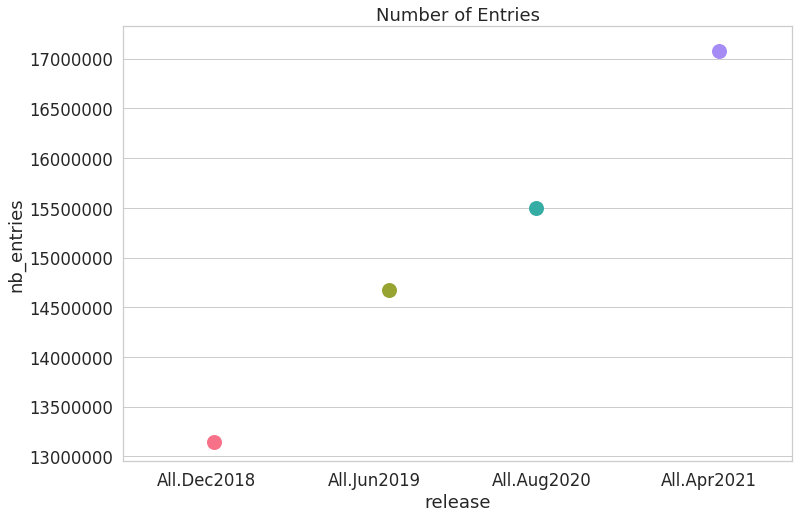

In [15]:
sns.stripplot(x="release", y="nb_entries",data=df, order=releases, size=15, palette="husl")
plt.title("Number of Entries")
plt.ticklabel_format(style='plain', axis='y')

# Compare OMA Groups

In [16]:
#get omagroups df
omagroups_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = get_nb_genes_per_group_df(release, "omagroup")
    omagroups_df = omagroups_df.append(tmp_df, ignore_index=True)

## Nb of omagroups

In [17]:
#total number of omagroups
get_total_nb_groups(omagroups_df)

release  nb_genomes
2  All.Dec2018      866647
3  All.Jun2019      918638
1  All.Aug2020      962065
0  All.Apr2021     1043597

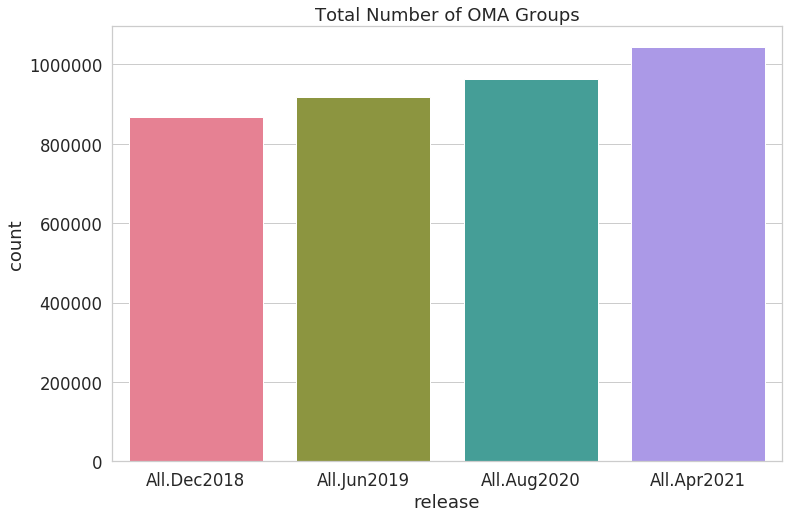

In [18]:
make_countplot_by_release(omagroups_df, releases, title="Total Number of OMA Groups")

## Nb genes per OMA Groups summary stats

In [19]:
get_summary_stats(omagroups_df, "nb_genes")

release      count       mean        std  min  25%  50%  75%     max
2  All.Dec2018   866647.0  11.575333  48.180143  2.0  2.0  3.0  7.0  2109.0
3  All.Jun2019   918638.0  11.943227  49.072848  2.0  2.0  3.0  7.0  2189.0
1  All.Aug2020   962065.0  11.941563  48.937634  2.0  2.0  3.0  7.0  2224.0
0  All.Apr2021  1043597.0  11.976146  49.317059  2.0  2.0  3.0  7.0  2298.0

## Plot distributions

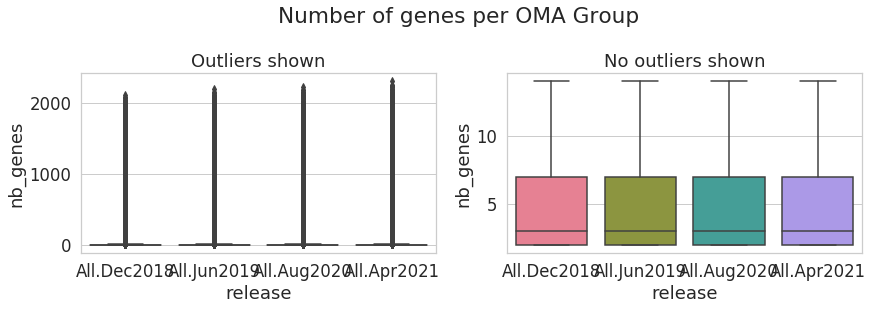

In [20]:
make_boxplot_by_release(omagroups_df, releases, "nb_genes","Number of genes per OMA Group")

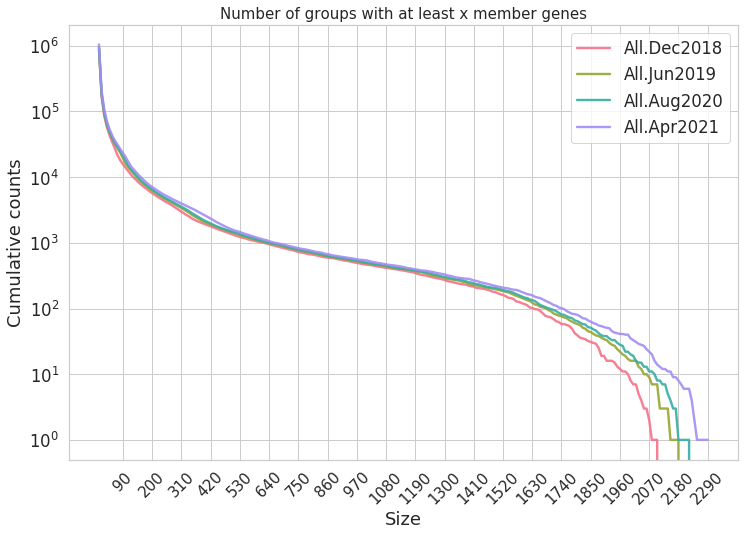

In [21]:
cum = cum_bin_cnts_by_release(omagroups_df, 'nb_genes')
make_cumbiggerthan_plot_by_release(cum, releases, 'Number of groups with at least x member genes')

## Groups with low numbers of genes

In [22]:
low_genes_df = get_low_genes_df(omagroups_df, releases)
low_genes_df

release  prop_groups_2_genes  prop_groups_3_genes  prop_groups_4_genes  \
0  All.Dec2018             0.421962             0.127163             0.076493   
1  All.Jun2019             0.421934             0.126622             0.076070   
2  All.Aug2020             0.425417             0.123879             0.075929   
3  All.Apr2021             0.434234             0.122851             0.074796   

   prop_groups_5_genes  total_nb_groups  
0             0.061356           866647  
1             0.061001           918638  
2             0.060019           962065  
3             0.059780          1043597

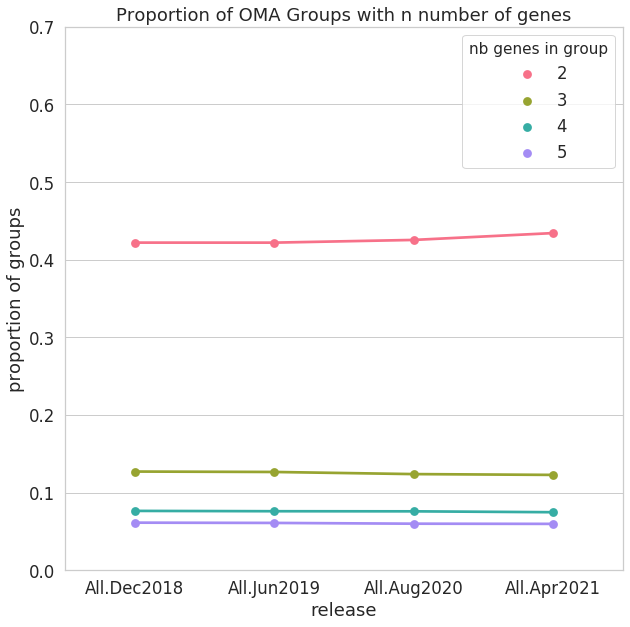

In [23]:
low_genes_df.rename({'prop_groups_2_genes':"2",'prop_groups_3_genes':"3",\
                     'prop_groups_4_genes':"4",'prop_groups_5_genes':"5"}, axis=1, inplace=True)


plot_proportions_of_groups_with_n_genes(low_genes_df, low_genes_df.columns[1:5],\
                                        "Proportion of OMA Groups with n number of genes")

# Compare HOGs (subhogs)

In [24]:
#get hog df
hog_df = pd.DataFrame()
fam_re = re.compile(rb'HOG:(?P<rel>[A-Z]?)(?P<fam>\d+)')
for release in sanity_sessions:
    tmp_df = get_nb_genes_per_group_df(release, "hog")
    hog_df = hog_df.append(tmp_df, ignore_index=True)
hog_df['depth'] = hog_df['hog'].apply(lambda x: x.count(b'.'))
hog_df['fam'] = hog_df['hog'].apply(lambda x: int(re_fam.match(x).group('fam')))

## Nb of hogs

In [25]:
#total number of hogs
get_total_nb_groups(hog_df)

release  nb_genomes
2  All.Dec2018     3014218
3  All.Jun2019     3246472
1  All.Aug2020     3477496
0  All.Apr2021     3751642

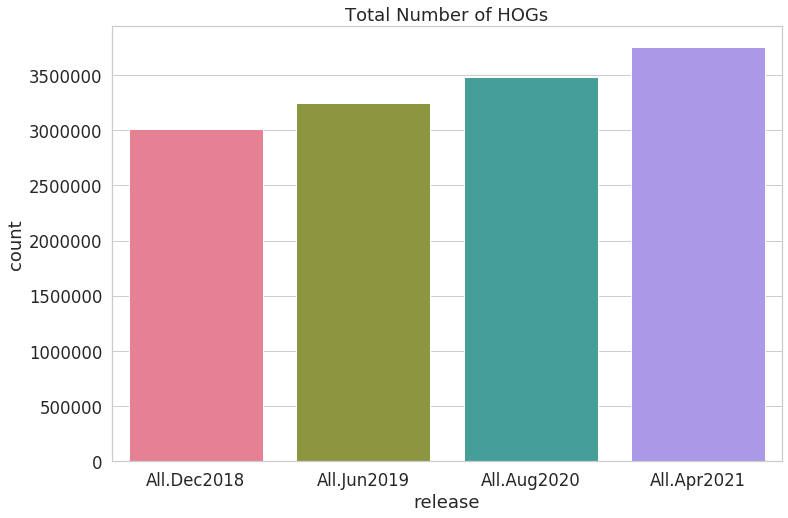

In [26]:
make_countplot_by_release(hog_df, releases, title="Total Number of HOGs")

## Nb genes per HOG summary stats

In [27]:
get_summary_stats(hog_df, "nb_genes")

release      count      mean         std  min  25%  50%  75%       max
2  All.Dec2018  3014218.0  7.609034  105.324665  1.0  1.0  1.0  3.0  131656.0
3  All.Jun2019  3246472.0  7.794307  103.778287  1.0  1.0  1.0  3.0  135172.0
1  All.Aug2020  3477496.0  7.753040  101.095238  1.0  1.0  1.0  3.0  133849.0
0  All.Apr2021  3751642.0  7.807804   83.496085  1.0  1.0  1.0  3.0   89345.0

In [28]:
get_summary_stats(hog_df, "depth")

release      count      mean       std  min  25%  50%  75%   max
2  All.Dec2018  3014218.0  1.596326  1.463815  0.0  1.0  1.0  2.0  17.0
3  All.Jun2019  3246472.0  1.583126  1.511038  0.0  1.0  1.0  2.0  19.0
1  All.Aug2020  3477496.0  1.633240  1.567690  0.0  1.0  1.0  2.0  18.0
0  All.Apr2021  3751642.0  1.631657  1.572265  0.0  1.0  1.0  2.0  18.0

## Plot distributions

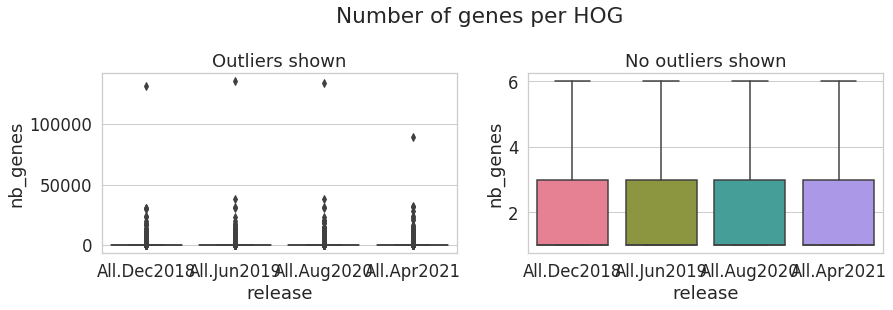

In [29]:
make_boxplot_by_release(hog_df, releases, "nb_genes", "Number of genes per HOG")

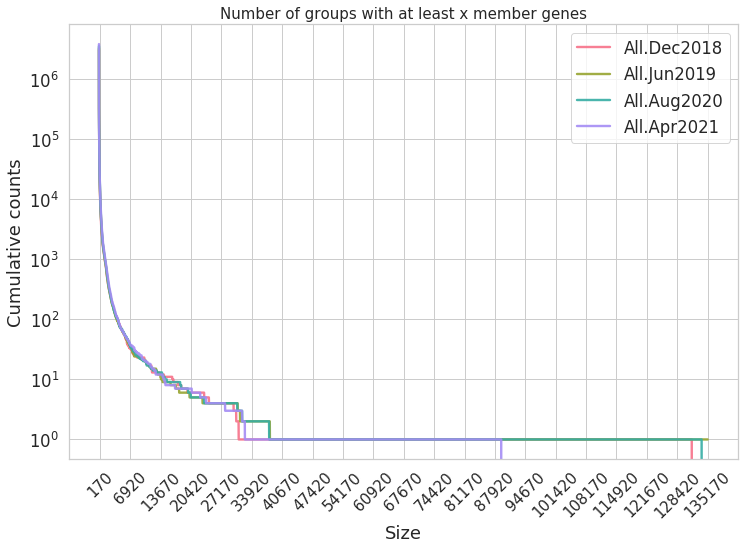

In [30]:
cum_hog = cum_bin_cnts_by_release(hog_df, 'nb_genes', bin_width=10)
make_cumbiggerthan_plot_by_release(cum_hog, releases, 'Number of groups with at least x member genes')

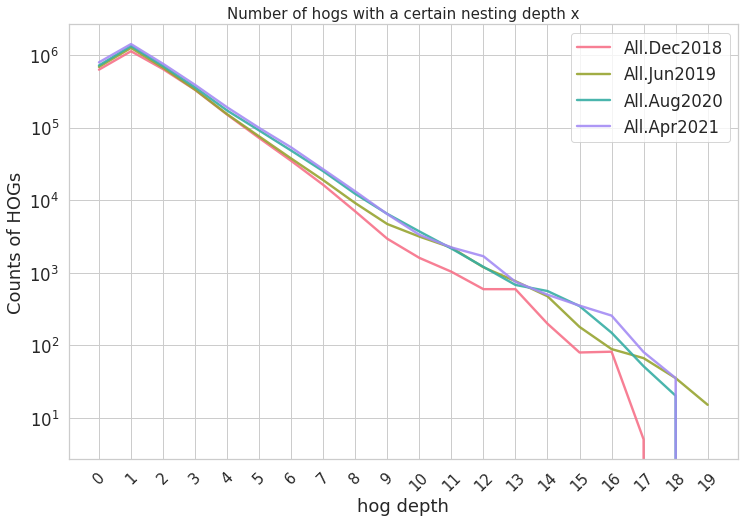

In [31]:
hog_depth = pd.DataFrame({rel: np.histogram(hog_df[hog_df['release']==rel]['depth'],bins=np.arange(0, max(hog_df['depth']+2), 1))[0] for rel in df['release'].unique()})
hog_depth['bin'] = np.arange(0, max(hog_df['depth']+1), 1)
make_cumbiggerthan_plot_by_release(hog_depth, releases, "Number of hogs with a certain nesting depth x", xlabel="hog depth", ylabel="Counts of HOGs")

## HOGs with low numbers

In [32]:
low_genes_df = get_low_genes_df(hog_df, releases, [1,2,3,4])
low_genes_df

release  prop_groups_1_genes  prop_groups_2_genes  prop_groups_3_genes  \
0  All.Dec2018             0.550825             0.166603             0.063312   
1  All.Jun2019             0.554220             0.164463             0.062767   
2  All.Aug2020             0.562402             0.162392             0.060905   
3  All.Apr2021             0.556935             0.169773             0.061304   

   prop_groups_4_genes  total_nb_groups  
0             0.043125          3014218  
1             0.043127          3246472  
2             0.042728          3477496  
3             0.041836          3751642

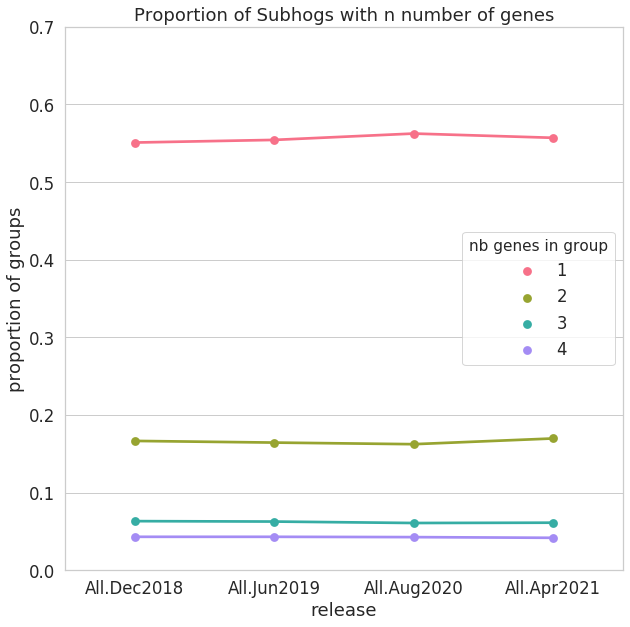

In [33]:
plot_proportions_of_groups_with_n_genes(low_genes_df, low_genes_df.columns[1:5],\
                                        "Proportion of Subhogs with n number of genes",\
                                       rename_cols=True)

# Compare families (root hogs)

In [34]:
fam_df = hog_df[hog_df['depth']==0]
fam_df.reset_index();

## Nb of families

In [35]:
#total number of families
get_total_nb_groups(fam_df)

release  nb_genomes
2  All.Dec2018      628448
3  All.Jun2019      685790
1  All.Aug2020      718347
0  All.Apr2021      792770

## Nb genes per fam summary stats

In [36]:
get_summary_stats(fam_df, "nb_genes")

release     count       mean         std  min  25%  50%  75%       max
2  All.Dec2018  628448.0  16.661872  222.774060  2.0  2.0  3.0  7.0  131656.0
3  All.Jun2019  685790.0  16.670405  218.451772  2.0  2.0  3.0  7.0  135172.0
1  All.Aug2020  718347.0  16.669657  214.707736  2.0  2.0  3.0  7.0  133849.0
0  All.Apr2021  792770.0  16.413037  171.699781  2.0  2.0  3.0  6.0   89345.0

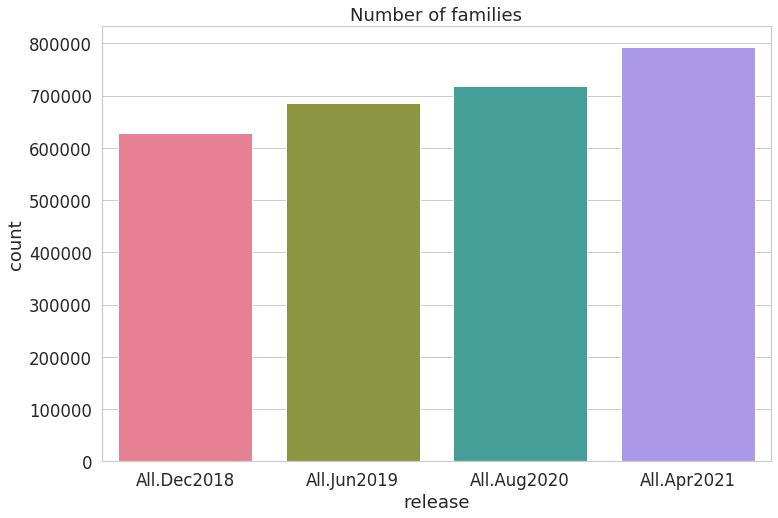

In [37]:
make_countplot_by_release(fam_df, releases, title="Number of families")

## Plot distributions

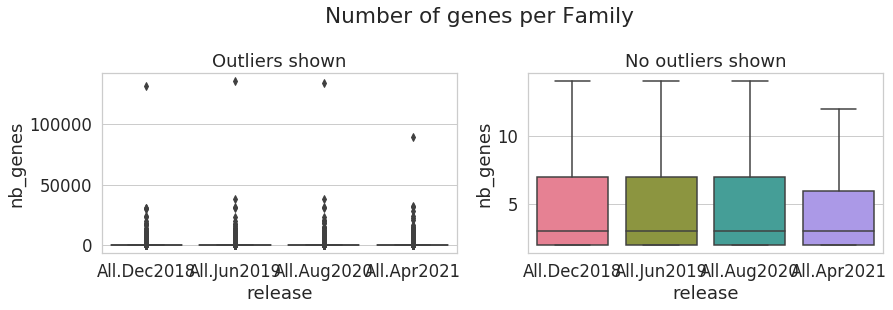

In [38]:
make_boxplot_by_release(fam_df, releases, "nb_genes","Number of genes per Family")

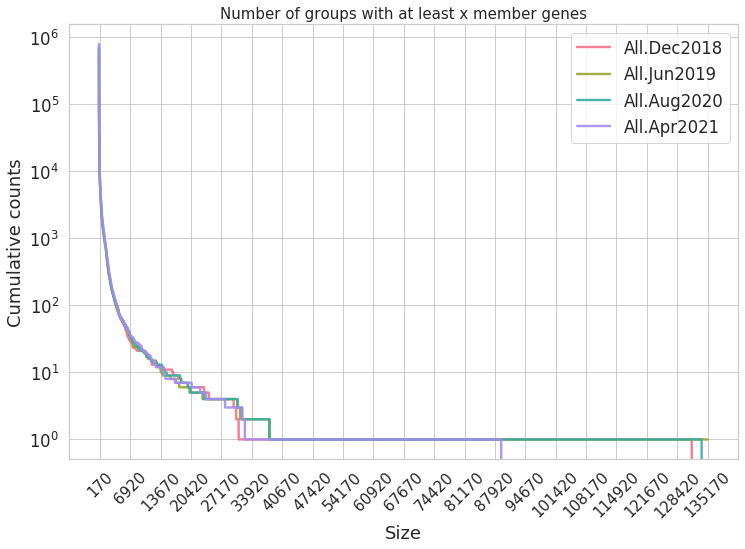

In [39]:
cum_fam = cum_bin_cnts_by_release(fam_df, 'nb_genes')
make_cumbiggerthan_plot_by_release(cum_fam, releases, 'Number of groups with at least x member genes')

## Families with low numbers

In [40]:
low_genes_df = get_low_genes_df(fam_df, releases, [2,3,4,5])
low_genes_df

release  prop_groups_2_genes  prop_groups_3_genes  prop_groups_4_genes  \
0  All.Dec2018             0.436074             0.135796             0.083248   
1  All.Jun2019             0.429070             0.134952             0.084349   
2  All.Aug2020             0.432359             0.133156             0.085584   
3  All.Apr2021             0.445642             0.130723             0.084394   

   prop_groups_5_genes  total_nb_groups  
0             0.047592           628448  
1             0.057566           685790  
2             0.057156           718347  
3             0.055668           792770

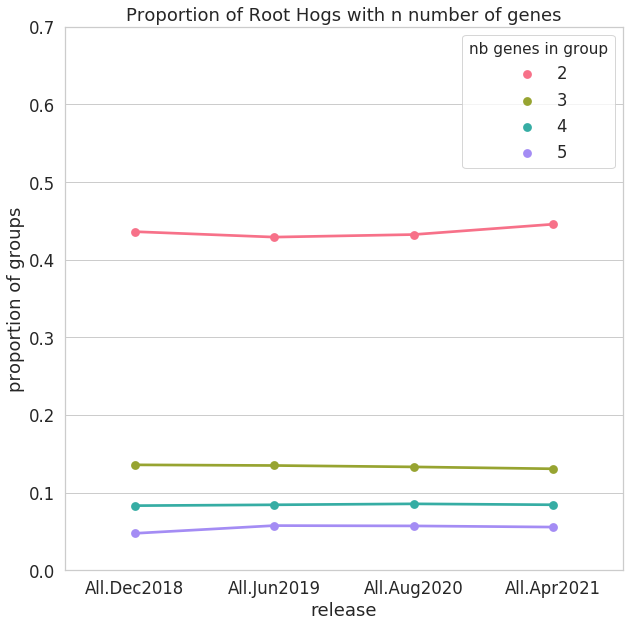

In [41]:
plot_proportions_of_groups_with_n_genes(low_genes_df, low_genes_df.columns[1:5],\
                                        "Proportion of Root Hogs with n number of genes",\
                                       rename_cols=True)


# Track HOGs for a few key genes

In [62]:
# cases reported once by BASF
query_genes = ["P53_HUMAN", ]
# a few random ARATH genes
query_genes.extend(["PME34_ARATH", "CYSK1_ARATH", "TO202_ARATH", "RIBA1_ARATH"])
# opsin gene where OMA doesn't work well (until Aug2020 at least)
query_genes.extend(["ENSG00000102076"])
import pyoma.browser.db
data = []
for release in sanity_sessions:
    db = pyoma.browser.db.Database(release.db_path)
    for query in query_genes:
        try:
            members = db.member_of_fam(db.hog_family(db.ensure_entry(db.id_resolver.resolve(query))))
        except pyoma.browser.db.InvalidId:
            print("{} does not contain an xref to {}".format(release.release, query))
            members = []
        except pyoma.browser.db.Singleton:
            print("{} is a singleton in {}".format(query, release.release))
            members = [1]
        data.append((query, release.release, len(members)))
    db.close()
case_df = pd.DataFrame(data, columns=["gene", "release", "size"])

outdated database version, but only minor version change: 3.2 != 3.4. Some functions might fail
Cannot load SequenceSearch. Any future call to seq_search will fail!
Traceback (most recent call last):
  File "/users/aaltenho/pyoma/pyoma/browser/db.py", line 1844, in __init__
    self.seq_idx = self.seq_idx()
  File "/scratch/axiom/FAC/FBM/DBC/cdessim2/oma/venv/lib64/python3.6/site-packages/tables/link.py", line 393, in __call__
    self.extfile = tables.open_file(filename, **kwargs)
  File "/users/aaltenho/pyoma/pyoma/browser/db.py", line 105, in synchronized_open_file
    return _tables_file._original_open_file(*args, **kwargs)
  File "/scratch/axiom/FAC/FBM/DBC/cdessim2/oma/venv/lib64/python3.6/site-packages/tables/file.py", line 315, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "/users/aaltenho/pyoma/pyoma/browser/db.py", line 95, in __init__
    super(ThreadsafeFile, self).__init__(*args, **kargs)
  File "/scratch/axiom/FAC/FBM/DBC/cdessim2

All.Dec2018 does not contain an xref to PME34_ARATH


outdated database version, but only minor version change: 3.2 != 3.4. Some functions might fail


ENSG00000102076 is a singleton in All.Apr2021


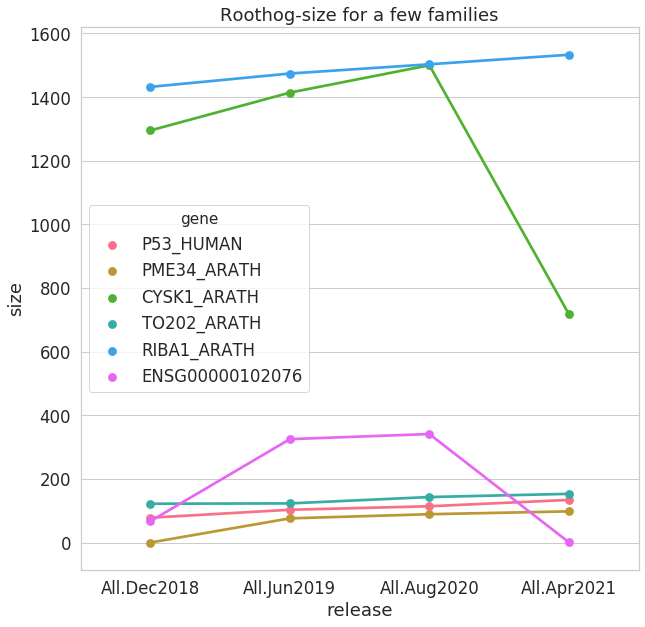

In [63]:
fig, ax= plt.subplots(figsize=(10,10))
sns.pointplot(x="release", y="size", hue="gene", data=case_df, palette=palette)
plt.title('Roothog-size for a few families')
plt.show()

# Compare at different taxa levels

In [44]:
tax_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = pd.DataFrame.from_dict(release.all_hog_lvls, orient="index")
    tmp_df = tmp_df.rename({0:'nb_hogs'}, axis=1)
    tmp_df = tmp_df.reset_index()
    tmp_df['release'] = release.release
    tax_df = tax_df.append(tmp_df)

tax_df.rename({'index':'taxa'}, axis=1, inplace=True)
tax_df['taxa'] = tax_df.apply(lambda x: x['taxa'].decode("utf-8"), axis=1)

## Nb of taxa levels

In [45]:
get_total_nb_groups(tax_df)

release  nb_genomes
2  All.Dec2018        3104
3  All.Jun2019        3236
1  All.Aug2020        3321
0  All.Apr2021        3493

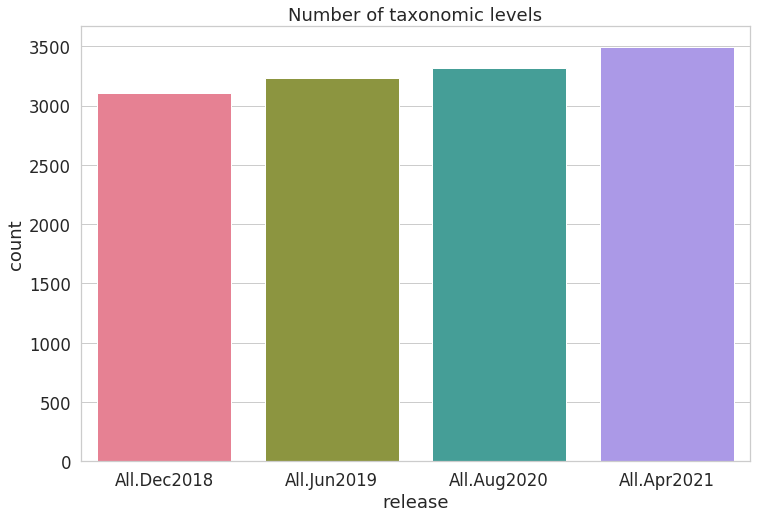

In [46]:
#number of taxa
make_countplot_by_release(tax_df, releases, title="Number of taxonomic levels")

## Nb hogs per taxa summary stats

In [47]:
#number of hogs per taxonomic level summary stats
get_summary_stats(tax_df, 'nb_hogs')

release   count         mean          std   min      25%     50%  \
2  All.Dec2018  3104.0  6317.118557  8297.162774  70.0  2101.50  3640.0   
3  All.Jun2019  3236.0  6677.863721  8733.239141  92.0  2133.75  3758.5   
1  All.Aug2020  3321.0  6888.554351  9108.900707  92.0  2148.00  3809.0   
0  All.Apr2021  3493.0  7205.104208  9332.822900  92.0  2199.00  3930.0   

       75%       max  
2  6321.50  102147.0  
3  6786.75  102163.0  
1  6943.00  102331.0  
0  7549.00  102333.0

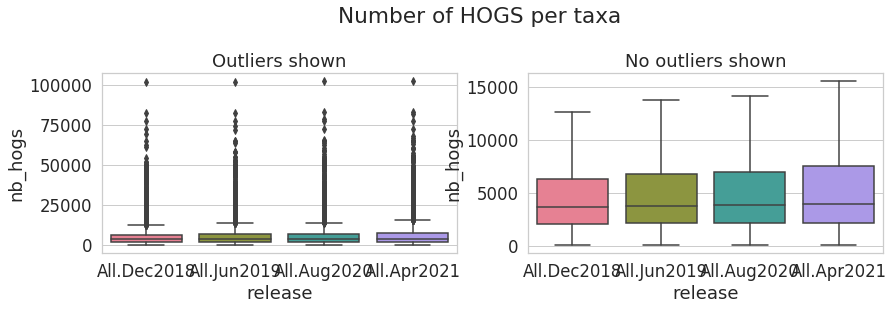

In [48]:
#distribution of number of hogs per taxa level
make_boxplot_by_release(tax_df, releases, 'nb_hogs', "Number of HOGS per taxa")

## Taxa added

In [49]:
old_release = sanity_sessions[-2]
new_release = sanity_sessions[-1]
get_differences_in_genomes_or_taxa(tax_df, old_release, new_release, "taxa")['added']

['Alicyclobacillus acidoterrestris (strain ATCC 49025 / DSM 3922 / CIP 106132 / NCIMB 13137 / GD3B)',
 'Tetraodontiformes',
 'Metakinetoplastina',
 'Trachipleistophora hominis',
 'Malassezia sympodialis (strain ATCC 42132)',
 'Candida auris',
 'Bipolaris',
 'Ajellomyces capsulatus (strain NAm1 / WU24)',
 'Planctomycetia',
 'Aspergillus subgen. Circumdati',
 'Listeria welshimeri serovar 6b (strain ATCC 35897 / DSM 20650 / CIP 8149 / NCTC 11857 / SLCC 5334 / V8)',
 'Penicillium nalgiovense',
 'Apinae',
 'mojavensis species complex',
 'Desulfomicrobium baculatum (strain DSM 4028 / VKM B-1378 / X)',
 'Mola mola',
 'Thermothelomyces thermophilus',
 'Natronomonas moolapensis (strain DSM 18674 / CECT 7526 / JCM 14361 / 8.8.11)',
 'Micromonospora sp. (strain ATCC 39149 / NRRL 15099 / SCC 1413)',
 'Corynebacterium resistens (strain DSM 45100 / JCM 12819 / GTC 2026 / SICGH 158)',
 'Weeksellaceae',
 'Dothideomycetes incertae sedis',
 'obscura subgroup',
 'Nitrosomonas eutropha (strain DSM 101675 

## Taxa removed

In [50]:
get_differences_in_genomes_or_taxa(tax_df, old_release, new_release, "taxa")['removed']

['Staphylococcus epidermidis (strain ATCC 12228)',
 'Eubacterium',
 'unclassified Archaea (miscellaneous)',
 'Kinetoplastida',
 'Francisella philomiragia subsp. philomiragia (strain ATCC 25017)',
 'Bradyrhizobium diazoefficiens (strain JCM 10833 / IAM 13628 / NBRC 14792 / USDA 110)',
 'Psychrobacter cryohalolentis (strain K5)',
 'Gluconacetobacter diazotrophicus (strain ATCC 49037 / DSM 5601 / PAl5)',
 'Corynebacterium resistens (strain DSM 45100 / JCM 12819 / GTC 2026)',
 'Pyrobaculum neutrophilum (strain DSM 2338 / JCM 9278 / V24Sta)',
 'Psychrobacter arcticus (strain DSM 17307 / 273-4)',
 'Catenulispora acidiphila (strain DSM 44928 / NRRL B-24433 / NBRC 102108 / JCM 14897)',
 'Streptomyces clavuligerus (strain ATCC 27064 / DSM 738 / JCM 4710 / NBRC 13307 / NCIMB 12785 / NRRL 3585 / VKM Ac-602)',
 'Leadbetterella byssophila (strain DSM 17132 / KACC 11308 / 4M15)',
 'Borreliella burgdorferi',
 'Geobacter metallireducens (strain GS-15 / ATCC 53774 / DSM 7210)',
 'Pyrobaculum arsenaticu

## Taxa with 2 genes in family

The following analysis uses the latest release. TODO: THIS IS NOT TRUE I THINK

In [51]:
#get families with 2 genes
families_2_genes = fam_df[(fam_df['nb_genes']==2) & (fam_df['release']==releases[3])]['fam']

#open up latest h5 file
with tables.open_file(oma_browser_dir+"/"+releases[3]+"/data/OmaServer.h5", "r") as h5file:
    #read hog level table and make df
    hog_level_df = pd.DataFrame(h5file.root.HogLevel.read())

KeyError: 'fam'

In [ ]:
#get rows with rootlevel taxa matching list of families w/ 2 genes
taxa_2_genes_at_root_df = hog_level_df[hog_level_df['Fam'].isin(families_2_genes)].\
                                                            drop_duplicates(subset='Fam').\
                                                            groupby('Level').\
                                                            size().\
                                                            reset_index().\
                                                            sort_values(0, ascending=False)
taxa_2_genes_at_root_df = taxa_2_genes_at_root_df.rename({0:"nb_families"}, axis=1)
taxa_2_genes_at_root_df = decode_column_in_df(taxa_2_genes_at_root_df, "Level")

In [ ]:
#top 20 taxa with the most families consisting of 2 genes
taxa_2_genes_at_root_df[:20]


# Compare Cross-references

In [52]:
xref_df = pd.DataFrame()
for session in sanity_sessions:
    tmp_df = session.xref_df
    tmp_df['release'] = session.release
    xref_df = xref_df.append(tmp_df, ignore_index=True)

## Total number of Crossreferences in dataset

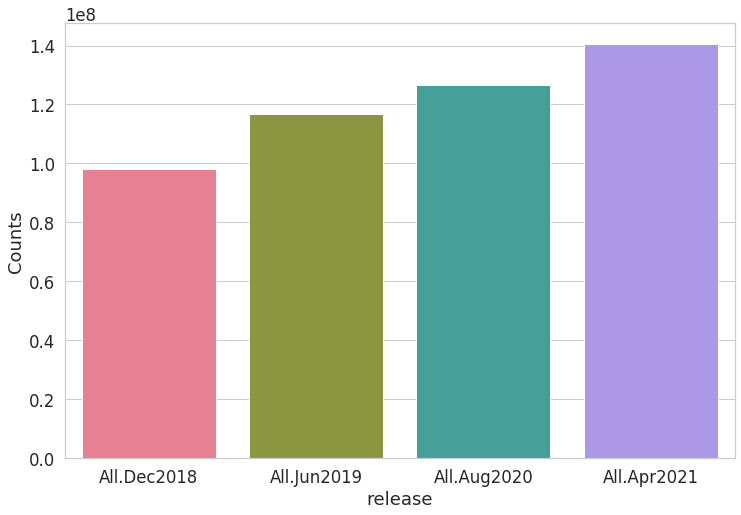

In [53]:
sns.barplot(data=xref_df.groupby(['release'])['Counts'].sum().reset_index(),
            x="release", y="Counts", order=releases, palette="husl")

## Nr of xrefs per source

We can distringuish between the different sources of cross-references. In general the number of cross-references should be more or less stable accross the different releases.

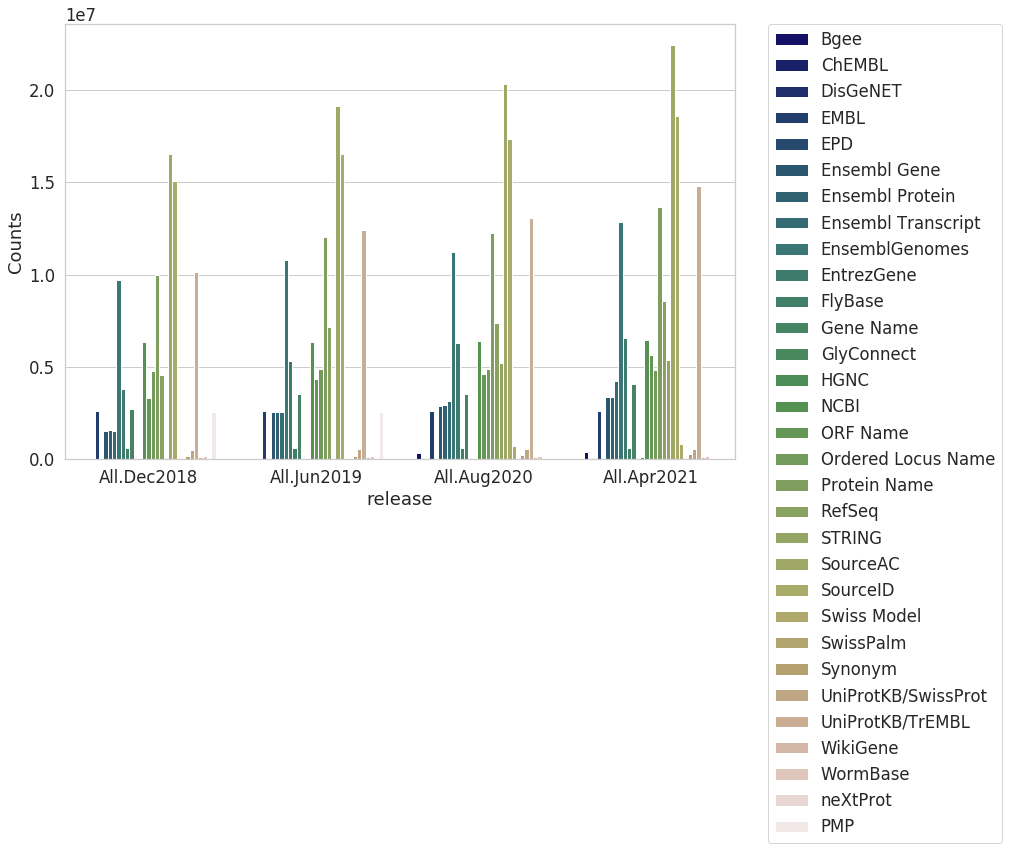

In [54]:
ax = sns.barplot(data=xref_df.groupby(['release', "Source"])['Counts'].sum().reset_index(),
             x="release", y="Counts", hue="Source", palette="gist_earth", order=releases)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

## Nr of xrefs per genome

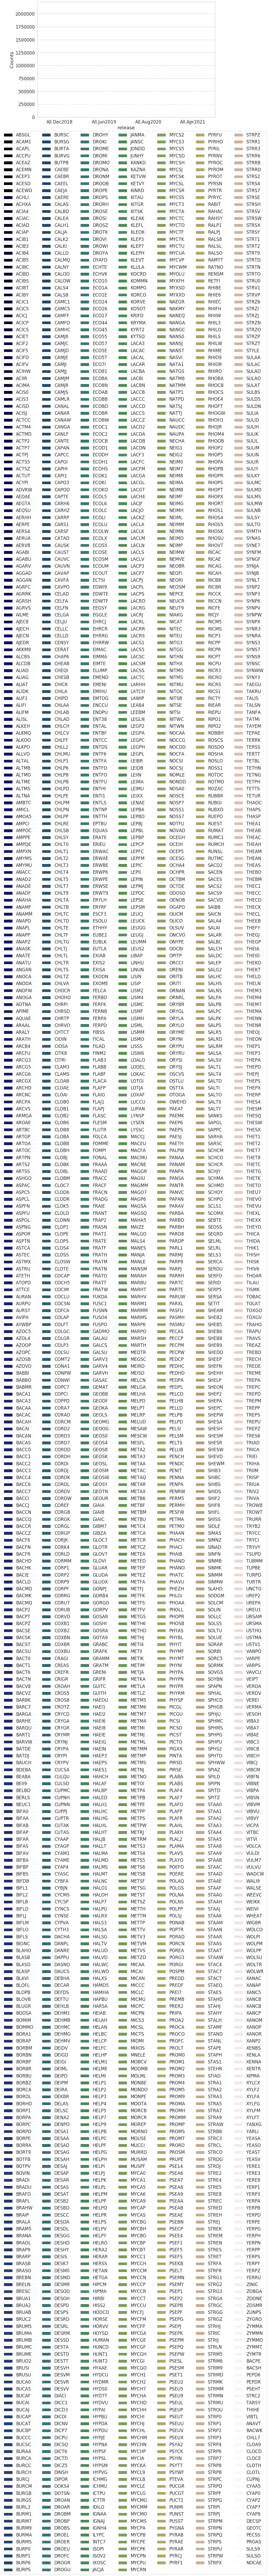

In [55]:
ax = sns.barplot(data=xref_df.groupby(["release", "Species"])["Counts"].sum().reset_index(),
                x="release", y="Counts", hue="Species", palette="gist_earth", order=releases)
ax.legend(bbox_to_anchor=(-0.2, -0.12), ncol=7, loc='upper left', borderaxespad=0.)

The above picture is not easy to read, but it shows the spread of crossreferences among the different species. More interpretable is the following figure. It shows the relative change in the number of crossreferences per species between the last two releases. Negative values mean that there are fewer crossreference in the newer release, positive indicate the oposite

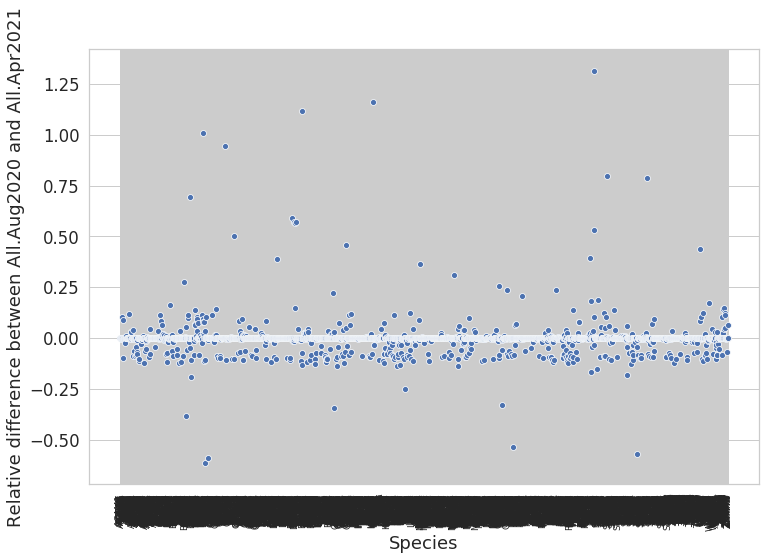

In [56]:
old = sanity_sessions[-2].xref_df.groupby(['Species'])['Counts'].sum()
new = sanity_sessions[-1].xref_df.groupby(['Species'])['Counts'].sum()
rel_diff = ((new-old)/old).reset_index()
rel_diff.rename(columns={'Counts':"Rel_diff"}, inplace=True)
ax = sns.scatterplot(data=rel_diff, x="Species", y="Rel_diff")
plt.xticks(rotation=90, fontsize=9)
ax.set_ylabel("Relative difference between {} and {}".format(releases[-2], releases[-1]));


In [57]:
sign_drop = rel_diff[rel_diff['Rel_diff'] < -0.15]
if len(sign_drop) > 0.2 * len(rel_diff):
    print("WARNING: {:.1f}% of all species have at least 15% less crossreferences!!".format(100*len(sign_drop)/len(rel_diff)))
print("In {} release, {} species have fewer crossreference than in {} release".format(releases[-1], len(rel_diff[rel_diff['Rel_diff']<0]), releases[-2]))

In All.Apr2021 release, 781 species have fewer crossreference than in All.Aug2020 release


## GO annotations

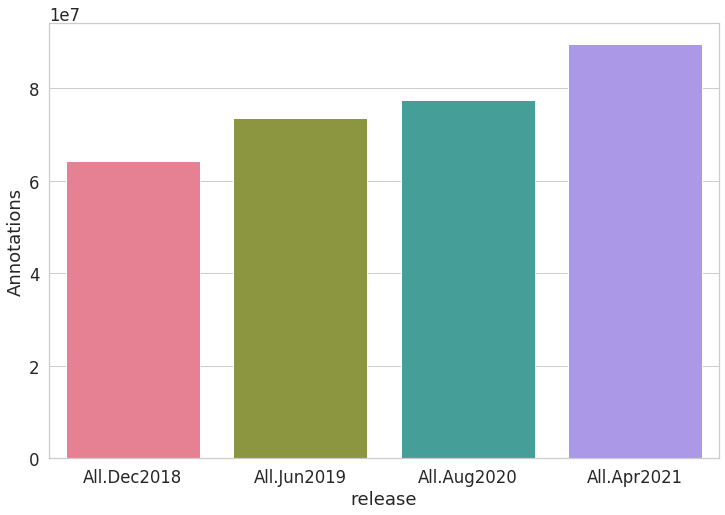

In [58]:
go_df = pd.DataFrame([(rel.release, len(rel.h5_handle.root.Annotations.GeneOntology)) for rel in sanity_sessions],
                     columns=["release", "Annotations"])
sns.barplot(data=go_df, x="release", y="Annotations", order=releases, palette="husl")

## EC annotations

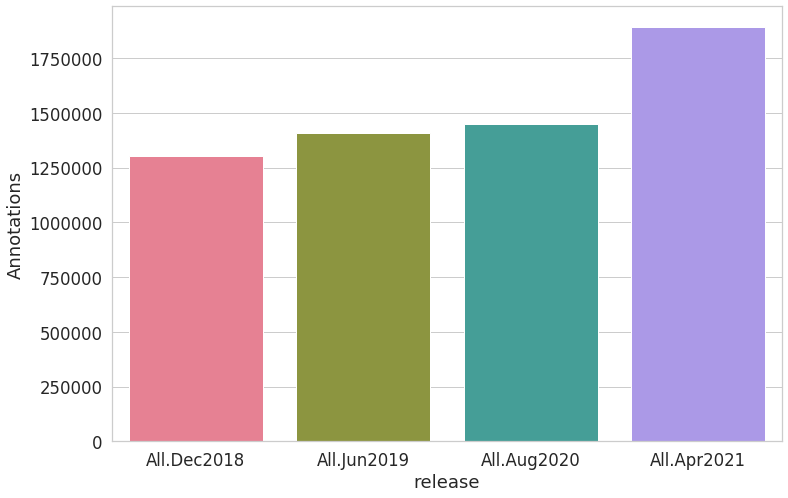

In [59]:
ec_df = pd.DataFrame([(rel.release, len(rel.h5_handle.root.Annotations.EC)) for rel in sanity_sessions],
                     columns=["release", "Annotations"])
sns.barplot(data=ec_df, x="release", y="Annotations", order=releases, palette="husl")

## Domain Annotations

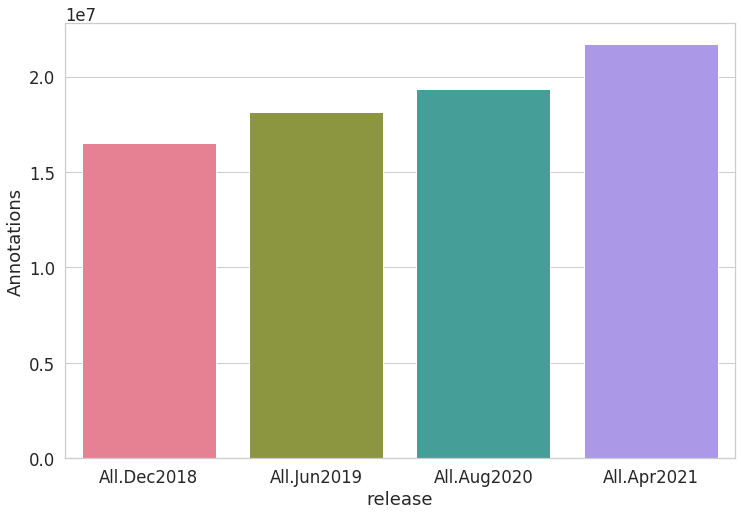

In [60]:
dom_df = pd.DataFrame([(rel.release, len(rel.h5_handle.root.Annotations.Domains)) for rel in sanity_sessions],
                     columns=["release", "Annotations"])
sns.barplot(data=dom_df, x="release", y="Annotations", order=releases, palette="husl")